<a href="https://colab.research.google.com/github/Khey17/100-Days-Of-ML-Code/blob/main/Learn-TensorFlow/Time_Series_Forecasting_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not a financial advice.

Links:
* [github-notes](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb)
* [Uber Forecast Blog](https://www.uber.com/en-IN/blog/forecasting-introduction/)

## Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: [Market-Watch](https://www.marketwatch.com/investing/cryptocurrency/btcusd/download-data#:~:text=Download%20CoinDesk%20Bitcoin%20Price%20Index%20(XBX)%20stock%20data:%20historical%20BTCUSD%20stock%20prices%20from%20MarketWatch.)

In [1]:
!wget https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/Download%20Data%20-%20CRYPTOCURRENCY_US_COINDESK_BTCUSD.csv

--2024-04-20 07:57:26--  https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/Download%20Data%20-%20CRYPTOCURRENCY_US_COINDESK_BTCUSD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17274 (17K) [text/plain]
Saving to: ‘Download Data - CRYPTOCURRENCY_US_COINDESK_BTCUSD.csv’

Download Data - CRY 100%[===================>]  16.87K  --.-KB/s    in 0.003s  

2024-04-20 07:57:27 (5.39 MB/s) - ‘Download Data - CRYPTOCURRENCY_US_COINDESK_BTCUSD.csv’ saved [17274/17274]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/Download Data - CRYPTOCURRENCY_US_COINDESK_BTCUSD.csv',
                 parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close
Date,,,,
2024-04-18,"60,998","64,148","60,800","63,546"
2024-04-17,"62,754","64,466","59,744","60,999"
2024-04-16,"63,371","63,876","61,727","62,755"
2024-04-15,"64,200","66,870","62,375","63,370"
2024-04-14,"64,838","65,568","60,908","64,200"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367 entries, 2024-04-18 to 2023-04-18
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    367 non-null    object
 1   High    367 non-null    object
 2   Low     367 non-null    object
 3   Close   367 non-null    object
dtypes: object(4)
memory usage: 14.3+ KB


In [5]:
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close
Date,,,,
2023-04-18,"29,485","30,480","29,136","30,239"
2023-04-19,"30,239","30,453","29,045","29,239"
2023-04-20,"29,239","29,317","28,010","28,100"
2023-04-21,"28,099","28,358","27,208","27,281"
2023-04-22,"27,281","27,775","27,153","27,629"


In [6]:
# How many samples do we have?
len(df)

367

We've collected the historical price of Bitcoin for the past ~1 year but there's 367 sampels.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples.

In [7]:
# remove commas from df and convert objects into float numbers
df.replace(',', '', regex=True, inplace=True)
df.head()

,Open,High,Low,Close
Date,,,,
2023-04-18,29485,30480,29136,30239
2023-04-19,30239,30453,29045,29239
2023-04-20,29239,29317,28010,28100
2023-04-21,28099,28358,27208,27281
2023-04-22,27281,27775,27153,27629


In [8]:
for col in list(df.columns):
  df[col] = df[col].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367 entries, 2023-04-18 to 2024-04-18
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    367 non-null    float64
 1   High    367 non-null    float64
 2   Low     367 non-null    float64
 3   Close   367 non-null    float64
dtypes: float64(4)
memory usage: 14.3 KB


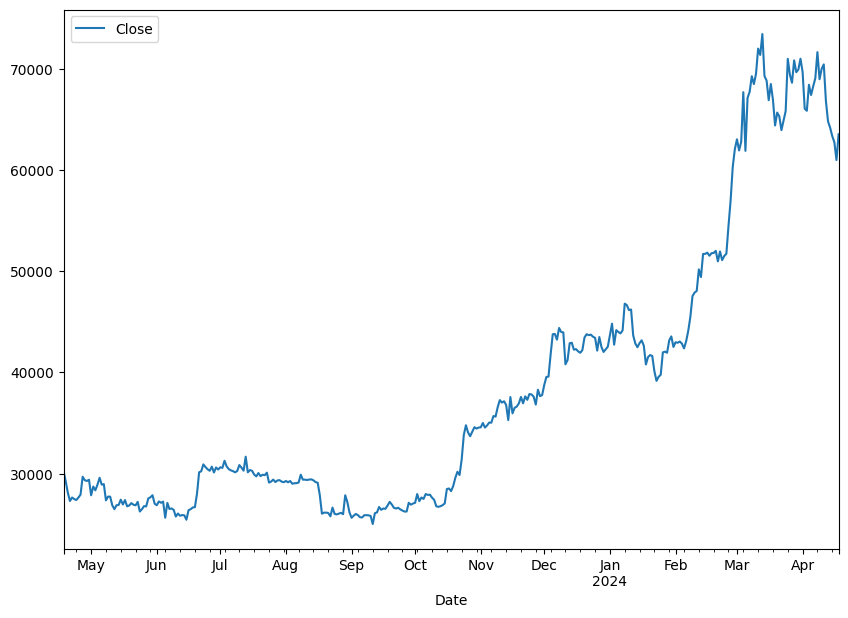

In [9]:
# plot Month Vs Closing Price
df.plot(y='Close', figsize=(10, 7))
plt.show()

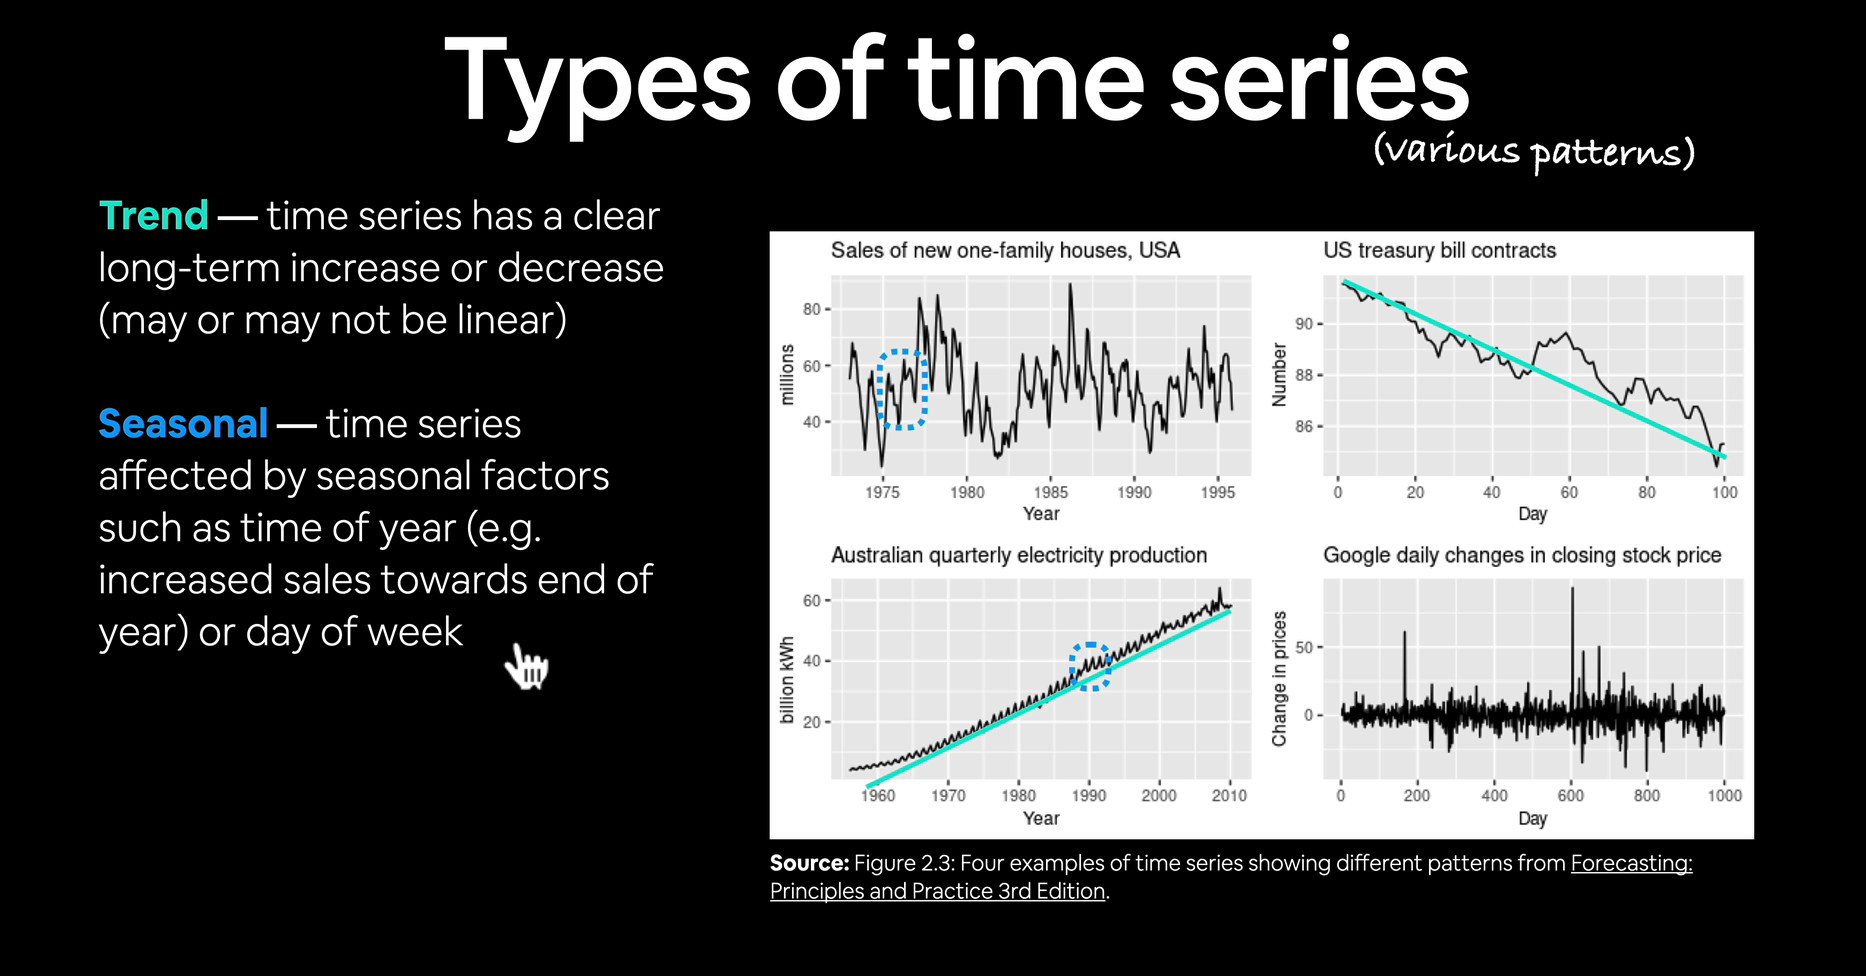

In [10]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices.head()

,Price
Date,
2023-04-18,30239.0
2023-04-19,29239.0
2023-04-20,28100.0
2023-04-21,27281.0
2023-04-22,27629.0


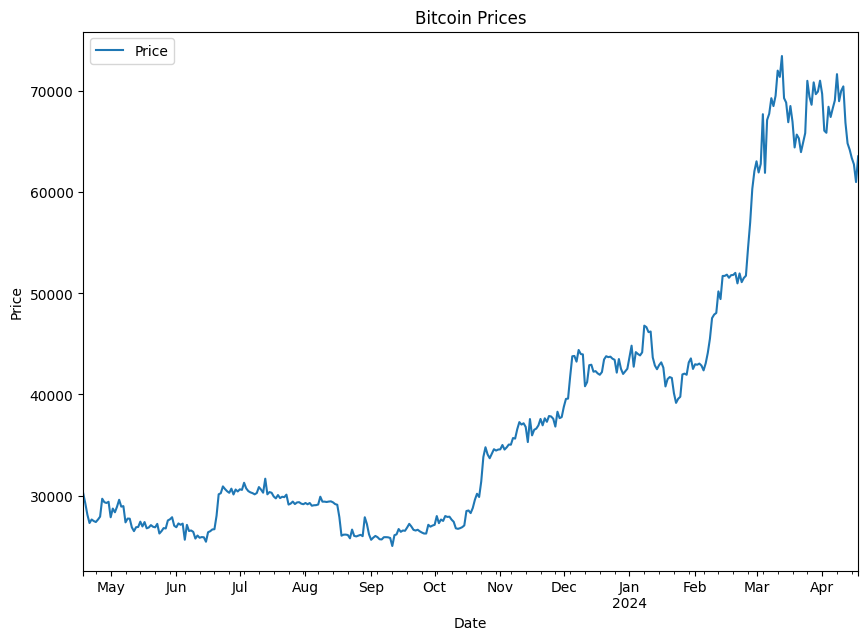

In [11]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('Price')
plt.title('Bitcoin Prices')
plt.show()

## Importing time series data with python's CSV module

In [24]:
# Importin and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open('/content/Download Data - CRYPTOCURRENCY_US_COINDESK_BTCUSD.csv', 'r') as f:
    csvreader = csv.reader(f, delimiter=',')
    next(csvreader) # Skip the header
    for row in csvreader:
        timesteps.append(datetime.strptime(row[0], '%m/%d/%Y'))
        btc_price.append(float(row[1].replace(',', '')))

timesteps[:5], btc_price[:5]

([datetime.datetime(2024, 4, 18, 0, 0),
  datetime.datetime(2024, 4, 17, 0, 0),
  datetime.datetime(2024, 4, 16, 0, 0),
  datetime.datetime(2024, 4, 15, 0, 0),
  datetime.datetime(2024, 4, 14, 0, 0)],
 [60998.0, 62754.0, 63371.0, 64200.0, 64838.0])

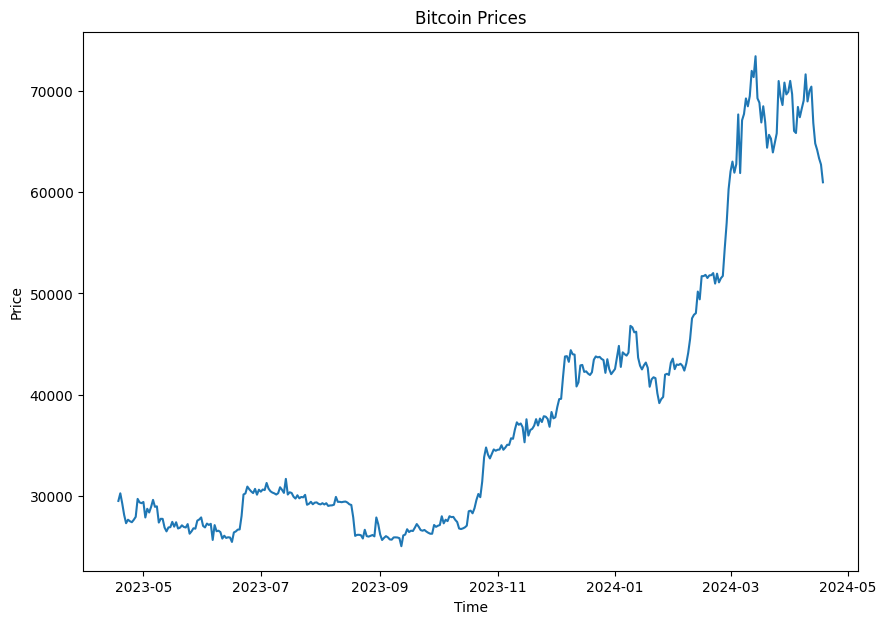

In [26]:
# Plot from CSV
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Prices')
plt.show()

## Create train and test sets of our time series data

### Creating train and test sets with time series data (WRONG WAY)

In [27]:
# Using scikit learn train_test_split
from sklearn.model_selection import train_test_split

# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

# Split into train and test sets (wrong way)
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices,
                                                    test_size=0.15, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((311,), (56,), (311,), (56,))

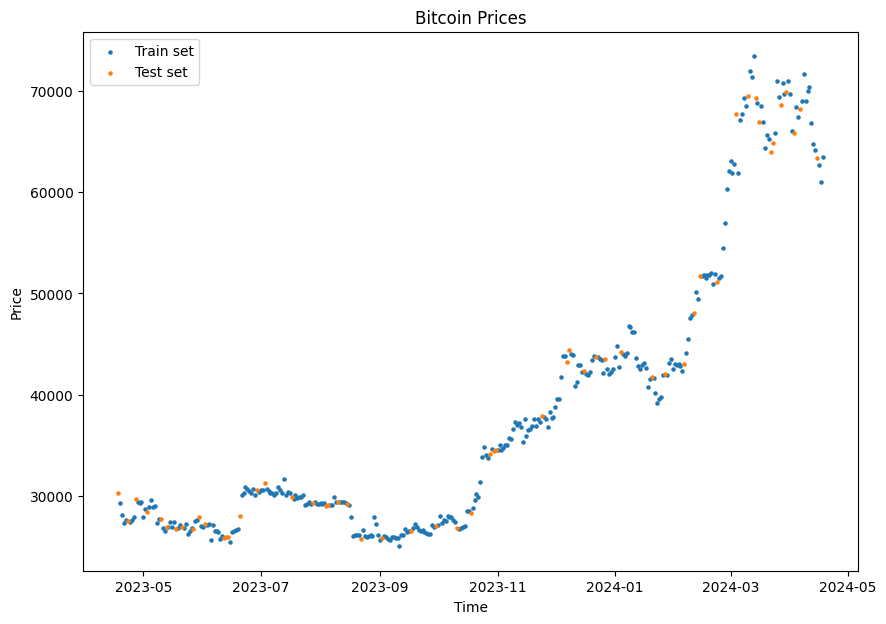

In [28]:
# Let's splot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train set')
plt.scatter(X_test, y_test, s=5, label='Test set')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Prices')
plt.legend()
plt.show()

### Creating train and test sets with time series data (RIGHT WAY)

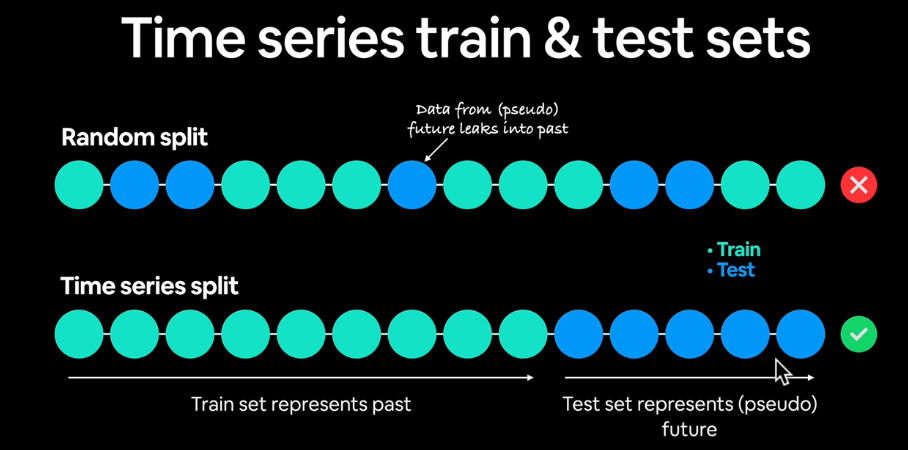

In [29]:
# Create train and test splits the right way
split_size = int(0.85 * len(prices)) # 85% of the train data, and 15% of the test data

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(311, 56, 311, 56)

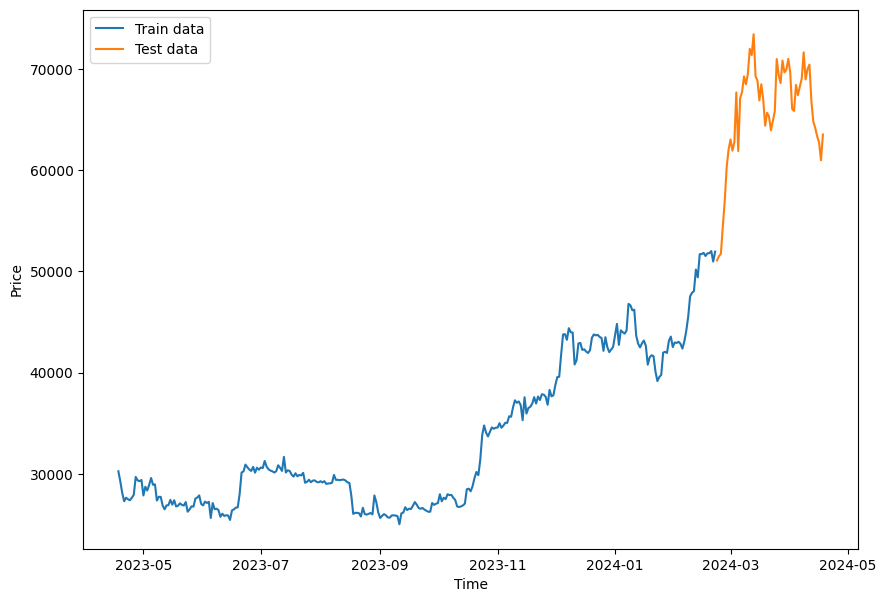

In [30]:
# Plot the correct split
plt.figure(figsize=(10, 7))
plt.plot(timesteps[:split_size], prices[:split_size], label="Train data")
plt.plot(timesteps[split_size:], prices[split_size:], label="Test data")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

## Create a plotting function

Typing plotting code is tedious, so let's create a function for it.

In [31]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  '''
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values
  label : label to show on plot of values
  '''
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end],
           format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize=14) # Make label bigger
  plt.grid(True)

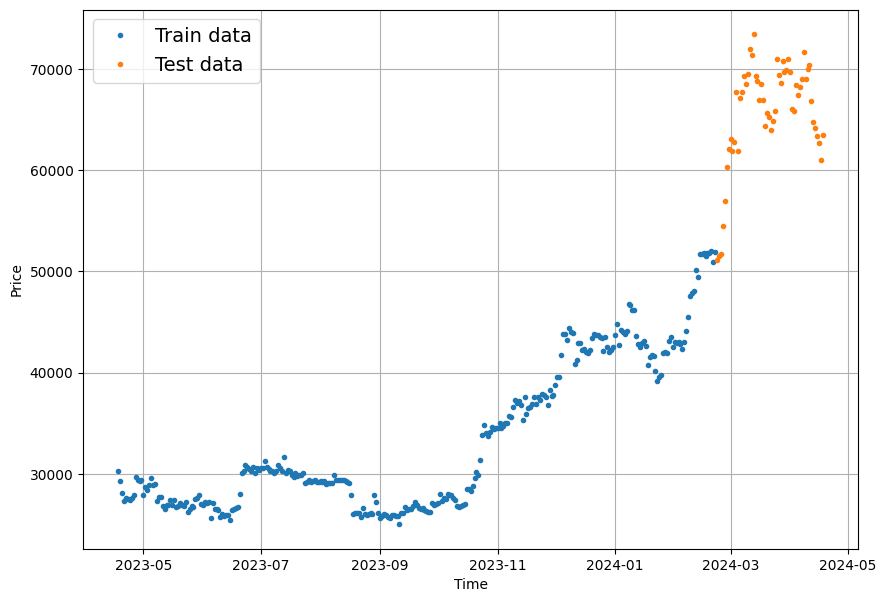

In [32]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict.
* **Window size** = number of timesteps we're going to use to predict **horizon**

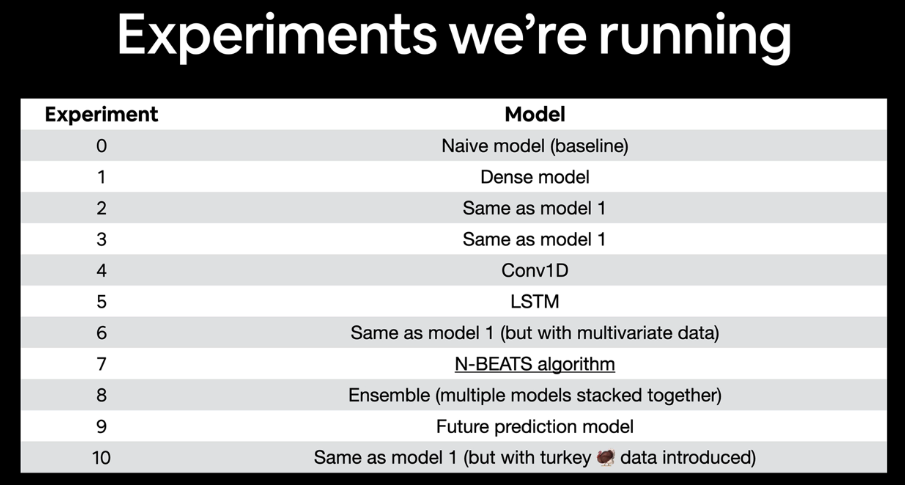

### Model 0: Naive model (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep t (y-hat) is equal to value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [38]:
# Create a navie forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([51101., 51510., 51738., 54479., 56989., 60312., 62074., 63053.,
        61947., 62794.]),
 array([71671., 68995., 70023., 70460., 66870., 64828., 64200., 63370.,
        62755., 60999.]))

In [42]:
len(naive_forecast), len(y_test)

(55, 56)

In [39]:
y_test[-10:]

array([68995., 70023., 70460., 66870., 64828., 64200., 63370., 62755.,
       60999., 63546.])

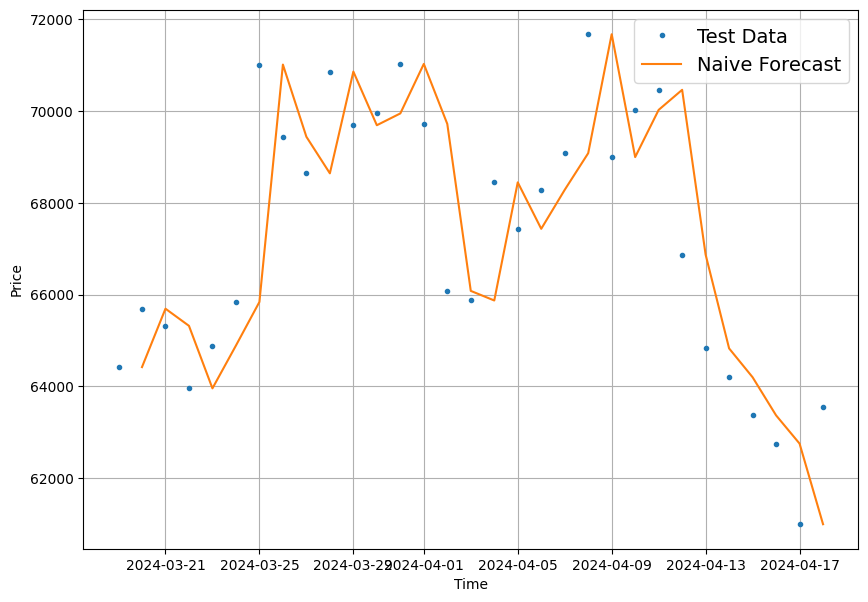

In [47]:
# Plot the naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label='Train Data')
plot_time_series(timesteps=X_test, values=y_test, start=25, label='Test Data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', start=25, label='Naive Forecast')

📃**Resource:** [Naive Forecast](https://otexts.com/fpp2/simple-methods.html)

Try to find why Naive's forecast is hard to beat.

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regreession problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

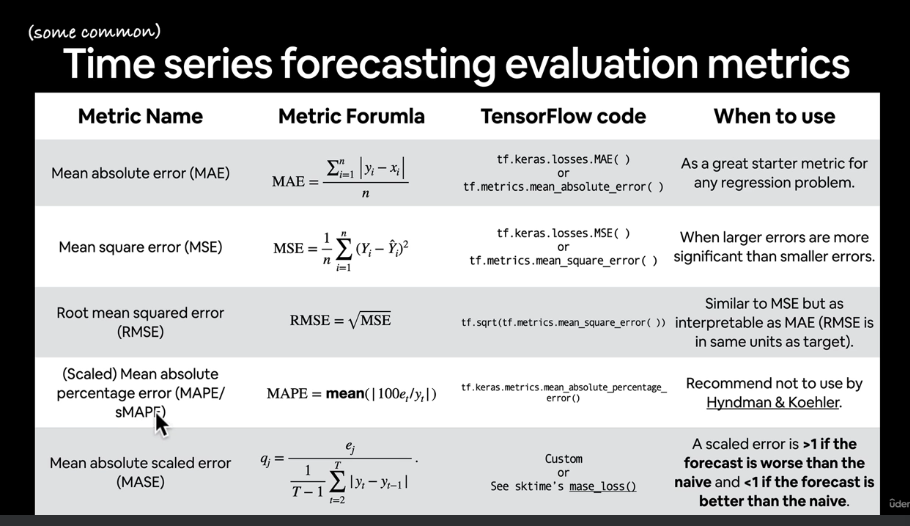